# Homework 5. Gradient descent. (10 points + 2.5 bonus points)

In this homework assignment, you will write gradient descent for linear regression and see how it behaves with different parameters and different loss functions.

Rules:

*Homework is worth 10 points.

* You can use without proof any results encountered in lectures or seminars in the course, if obtaining these results is not the issue of the assignment.

* You can use any free sources with *obligatory* indication of a link to them.

*Plagiarism is not allowed. If cases of cheating are detected, 0 for the work is assigned to all participants in the violation, even if it is possible to determine who cheated from whom.

* Try to make the code as optimal as possible. In particular, the use of loops will be penalized in cases where the operation can be performed using library tools that were discussed in the course.

In [2]:
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np

## Part 1. Gradient descent (5 points)

First, let's remember the simplest error functional that we use in a regression problem - Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

where $x_i$ is the $i$th object in the dataset, $y_i$ is the correct answer for the $i$th object, and $w$ are the weights of our linear model.

As we remember, for a linear model, it can be written in matrix form like this:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

where $X$ is the feature-object matrix, and $y$ is the vector of correct answers

In order to use the gradient descent method, we need to calculate the gradient of our functional. For MSE it will look like this:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения градиента (вектор)

In [ ]:
import abc


class BaseLoss(abc.ABC):
     """Loss base class"""

     @abc.abstractmethod
     def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
         """
         Function for calculating loss value
         :param X: np.ndarray of size (n_objects, n_features) with dataset objects
         :param y: np.ndarray of size (n_objects,) with correct answers
         :param w: np.ndarray of size (n_features,) with linear regression weights
         :return: number -- loss function values
         """
    
        
         raise NotImplementedError

     @abc.abstractmethod
     def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
         """
         Function for calculating the loss gradient by weights w
         :param X: np.ndarray of size (n_objects, n_features) with dataset objects
         :param y: np.ndarray of size (n_objects,) with correct answers
         :param w: np.ndarray of size (n_features,) with linear regression weights
         :return: np.ndarray of size (n_features,) gradient of the loss function over weights w
         """
         raise NotImplementedError

Now let's write an implementation of this abstract class: Mean Squared Error loss.

**Task 1.1 (5/8 points):** Implement the `MSELoss` class

It should calculate the loss and gradient using the formulas above

In [ ]:
class MSELoss(BaseLoss):
     def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
         """
         Function for calculating loss value
         :param X: np.ndarray of size (n_objects, n_features) with dataset objects
         :param y: np.ndarray of size (n_objects,) with correct answers
         :param w: np.ndarray of size (n_features,) with linear regression weights
         :return: number -- loss function values
         """
         # -- YOUR CODE HERE --
         # Compute the value of the loss function using X, y and w and return it
         return (np.linalg.norm(X.dot(w) - y))**2/y.shape[0]
    
        

     def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
         """
         Function for calculating the loss gradient by weights w
         :param X: np.ndarray of size (n_objects, n_features) with dataset objects
         :param y: np.ndarray of size (n_objects,) with correct answers
         :param w: np.ndarray of size (n_features,) with linear regression weights
         :return: np.ndarray of size (n_features,) gradient of the loss function over weights w
         """
         # -- YOUR CODE HERE --
        
         return (2/y.shape[0]) * X.T@(X.dot(w) - y)

In [6]:
# Lets create loss object
loss = MSELoss()

# Lets create some dataset
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Let's create some weights vector
w = np.arange(10)

print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]


Now we can create an `MSELoss` object and use it to calculate the value of our loss function and gradients:

In [7]:
# Let's create loss object
loss = MSELoss()

# Let's create some dataset
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Create weights vector
w = np.arange(10)


print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Check the methods
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Now that we have everything to calculate a gradient, let's write our gradient descent. Recall that the formula for one iteration of gradient descent is as follows:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Where $w^t$ is the value of the weight vector at the $t$th iteration, and $\eta$ is the learning rate parameter responsible for the step size.

**Task 1.2 (5/8 points):** Implement the `gradient_descent` function

The function must take as input the initial value of the weights of the linear model `w_init`, the matrix of feature objects `X`,
the vector of correct answers `y`, the loss function object `loss`, the step size `lr` and the number of iterations `n_iterations`.

The function should implement a loop that does a gradient descent step (gradients are taken from `loss` by calling the `calc_grad` method) using the formula above and return
descent trajectory (list of new weight values at each step)

In [ ]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Gradient descent function
     :param w_init: np.ndarray of size (n_feratures,) -- initial value of the weights vector
     :param X: np.ndarray of size (n_objects, n_features) -- matrix of object-features
     :param y: np.ndarray of size (n_objects,) -- vector of correct answers
     :param loss: An object of the BaseLoss subclass that can calculate gradients using loss.calc_grad(X, y, w)
     :param lr: float -- step size parameter by which to multiply the gradient
     :param n_iterations: int -- how many iterations to do
     :return: List of n_iterations np.ndarray objects of size (n_features,) -- history of weights at each step
    """
    # -- YOUR CODE HERE --
    listt  = []
    for i in range(n_iterations):
        new_w = w_init - (lr * loss.calc_grad(X, y, w_init))
        listt.append(w_init)
        w_init = new_w
    return listt 


Now let’s create a synthetic dataset and a function that will draw a gradient descent trajectory through history:

In [208]:
# Create a dataset from two variables and a real dependency vector w_true

np.random.seed(505)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [28]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

97.89809703859642
0.973880964221409


In [29]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
     Function for drawing gradient descent trajectory
     :param w_list: List of np.ndarray objects of size (n_features,) -- history of weights at each step
     :param X: np.ndarray of size (n_objects, n_features) -- matrix of object-features
     :param y: np.ndarray of size (n_objects,) -- vector of correct answers
     :param loss: An object of the BaseLoss subclass that can calculate loss using loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 11))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**Task 1.3 (5/8 points):** Using the `gradient_descent` and `plot_gd` functions, draw a gradient descent trajectory for different values of the step length (the `lr` parameter). Use at least four different values for `lr`.

Draw and describe your conclusions about how the `lr` parameter affects the behavior of gradient descent

Tips:
* The `gradient_descent` function returns the history of weights, which must be fed to the `plot_gd` function
* Good values for `lr` can be between 0.0001 and 0.1

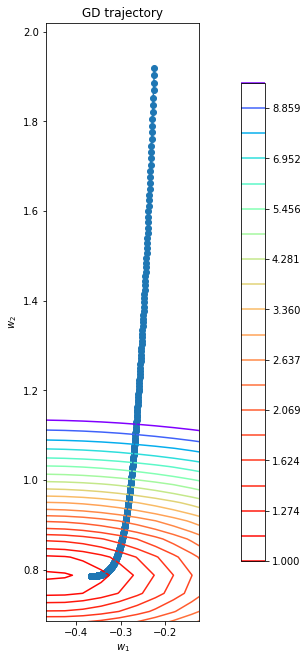

lr равен 0.0001 loss = 1.0463674849532278




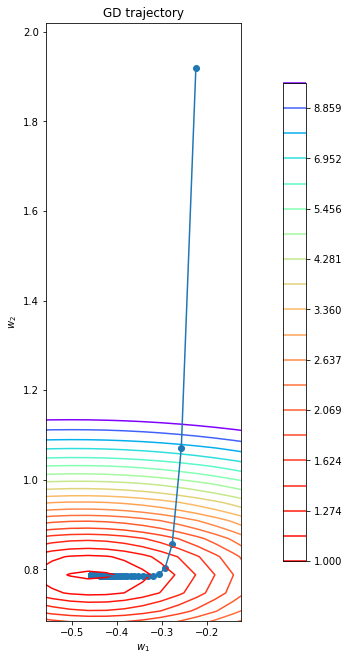

lr равен 0.005 loss = 0.9738809642214085




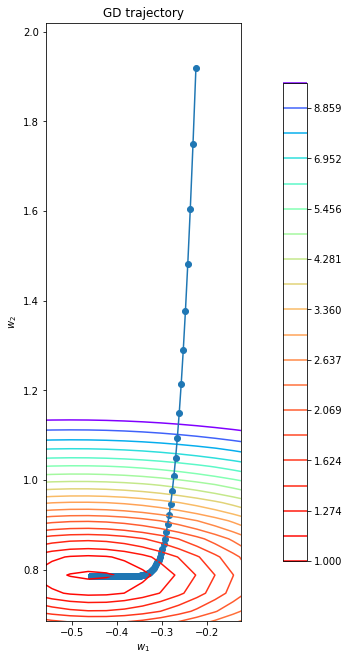

lr равен 0.001 loss = 0.9738809804738584




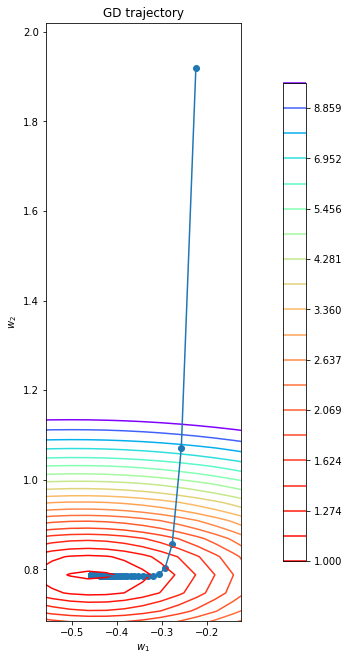

lr равен 0.005 loss = 0.9738809642214085




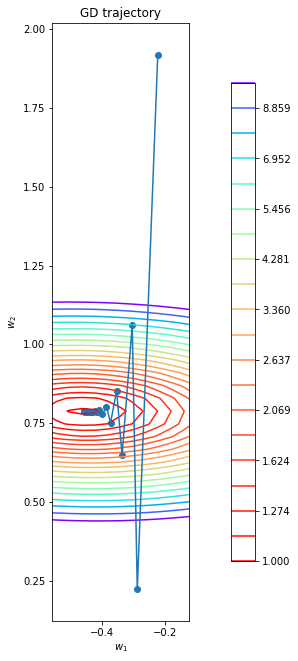

lr равен 0.01 loss = 0.973880964221409




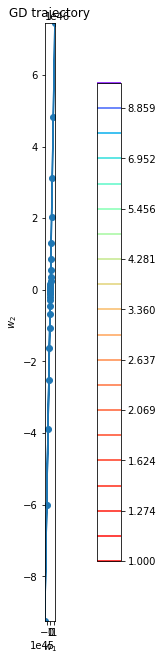

lr равен 0.015 loss = 6.390109892710082e+95




In [12]:
# -- YOUR CODE HERE --
lr_list = [0.0001, 0.005, 0.001, 0.005, 0.01, 0.015]
loss = MSELoss()
for i in lr_list:
    w_list = gradient_descent(w_init, X, y, loss, lr=i, n_iterations = 500)
    plot_gd(w_list, X=X, y=y, loss = loss)
    print(f'lr равен {i}', f'loss = {loss.calc_loss(X, y, w_list[-1])}', end = '\n\n\n')

### Conclusions
With a small learning rate we do not reach the minimum (albeit a little), and with a large step we fly past the minimum (not visible on the graph, but we can assume this from the error value)

Now let's implement stochastic gradient descent

**Task 1.4 (5/8 points):** Implement the `stochastic_gradient_descent` function

The function should take all the same parameters as the `gradient_descent` function, but also the `batch_size` parameter, which is responsible for the batch size.

The function should, as before, implement a loop in which the gradient descent step occurs, but at each step, calculate the gradient not over the entire sample `X`, but only over a randomly selected part.

Hint: to select a random part you can use [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) with the correct `size` parameter to select random indices, and then index the resulting array into the `X` array:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [18]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Gradient descent function
     :param w_init: np.ndarray of size (n_feratures,) -- initial value of the weights vector
     :param X: np.ndarray of size (n_objects, n_features) -- matrix of object-features
     :param y: np.ndarray of size (n_objects,) -- vector of correct answers
     :param loss: An object of the BaseLoss subclass that can calculate gradients using loss.calc_grad(X, y, w)
     :param lr: float -- step size parameter by which to multiply the gradient
     :param batch_size: int -- size of the subsample to be sampled at each step
     :param n_iterations: int -- how many iterations to do
     :return: List of n_iterations np.ndarray objects of size (n_features,) -- history of weights at each step
    """

    batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
    batch_x = X[batch_indices]
    bacth_y = y[batch_indices]


    listt  = []
    for i in range(n_iterations):
        new_w = w_init - (lr * loss.calc_grad(batch_x, bacth_y, w_init))
        listt.append(w_init)
        w_init = new_w
    


   
    
    return listt 
    


**Task 1.5 (5/8 points):** Using the `stochastic_gradient_descent` and `plot_gd` functions, draw a gradient descent trajectory for different values of the step length (the `lr` parameter) and the subsample size (the `batch_size` parameter). Use at least four different values for `lr` and `batch_size`.

Draw and describe your conclusions about how the `lr` and `batch_size` parameters affect the behavior of stochastic gradient descent. How does the behavior of stochastic gradient descent differ from regular one?

Note that there are only 300 objects in our dataset, so a `batch_size` larger than this number will not make sense.

'равен' in output below means 'equals'

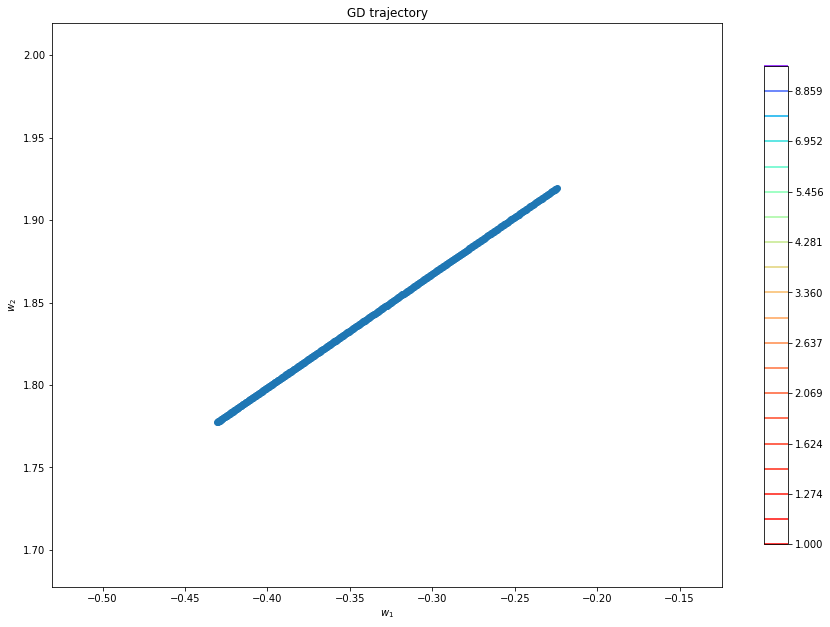

lr равен 0.0001, batch_size равен 1 loss = 74.37996585480691




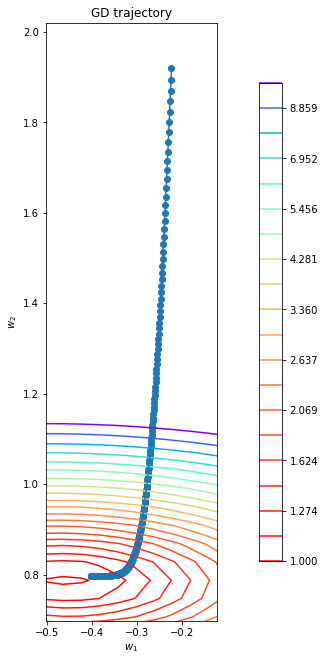

lr равен 0.0001, batch_size равен 10 loss = 1.0128338372818886




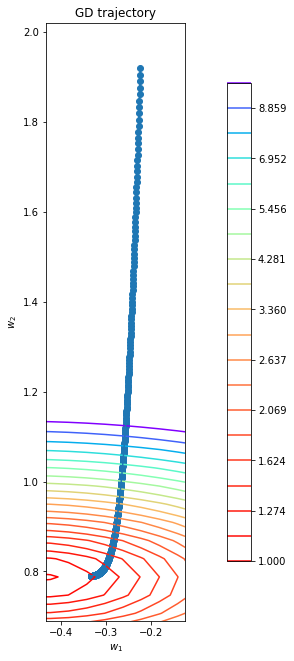

lr равен 0.0001, batch_size равен 50 loss = 1.1073376622998945




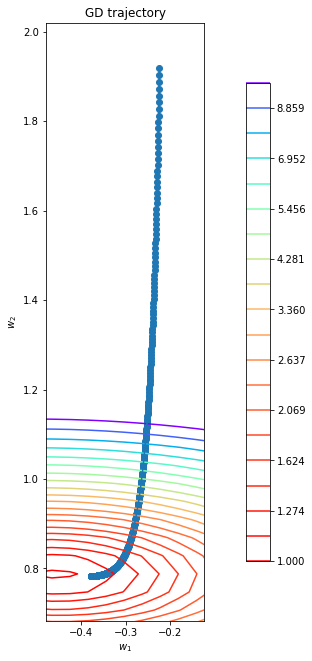

lr равен 0.0001, batch_size равен 100 loss = 1.029990541429681




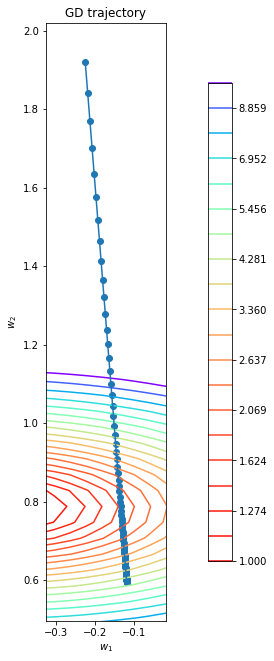

lr равен 0.001, batch_size равен 1 loss = 4.524587189764389




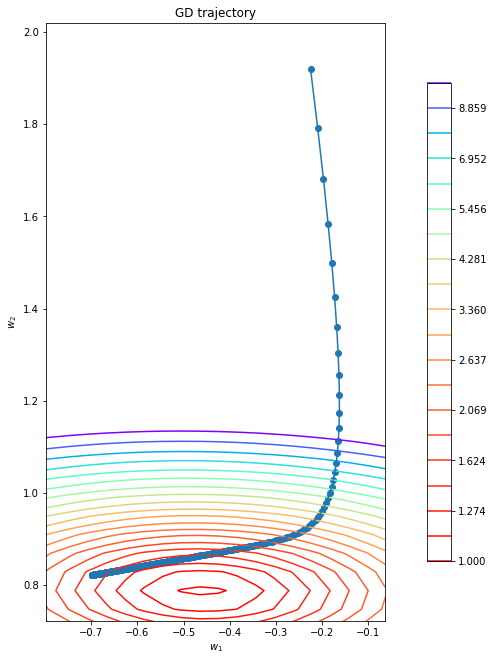

lr равен 0.001, batch_size равен 10 loss = 1.5330556734860796




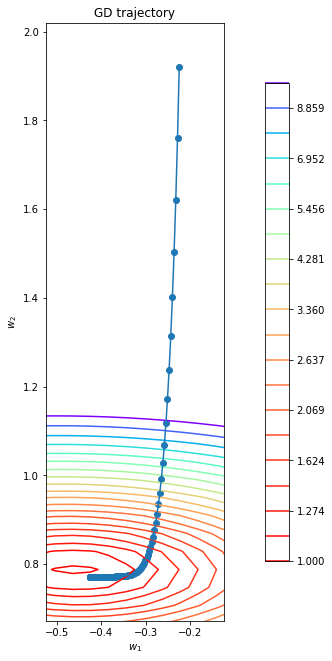

lr равен 0.001, batch_size равен 50 loss = 0.9993519490405315




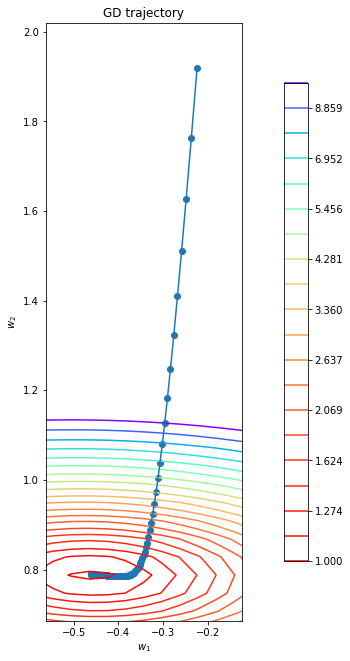

lr равен 0.001, batch_size равен 100 loss = 0.9743969648375636




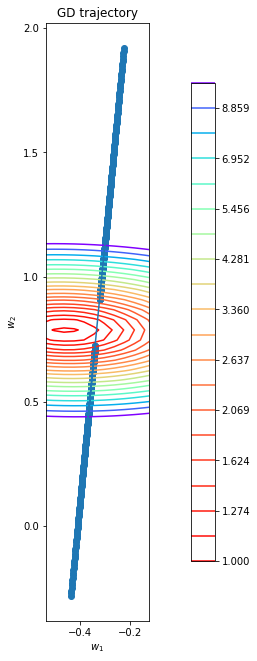

lr равен 0.005, batch_size равен 1 loss = 1.3683265160063671




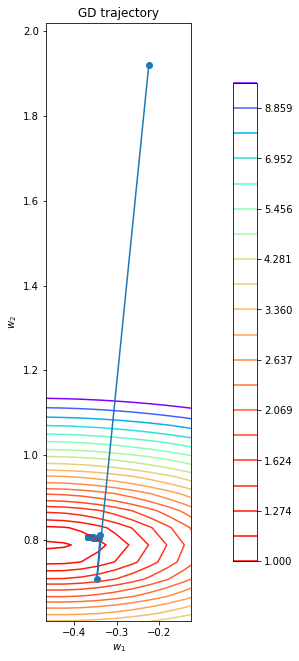

lr равен 0.005, batch_size равен 10 loss = 1.0787486160844828




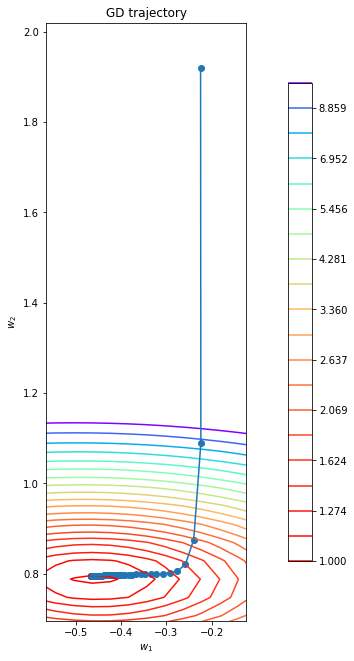

lr равен 0.005, batch_size равен 50 loss = 0.9795348297965143




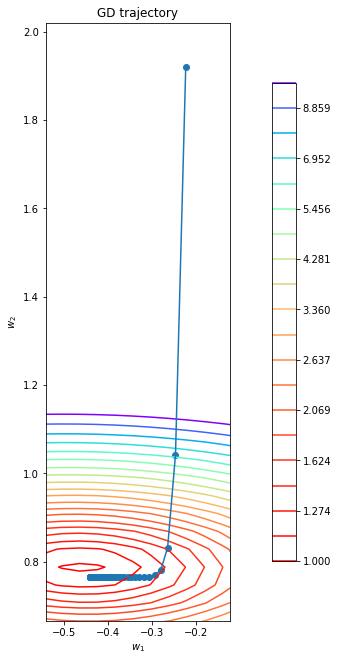

lr равен 0.005, batch_size равен 100 loss = 1.0064807226603945




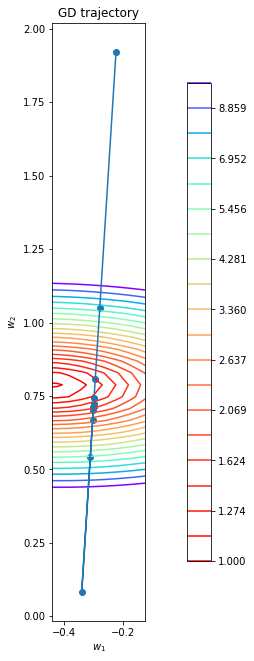

lr равен 0.01, batch_size равен 1 loss = 1.5240053462763594




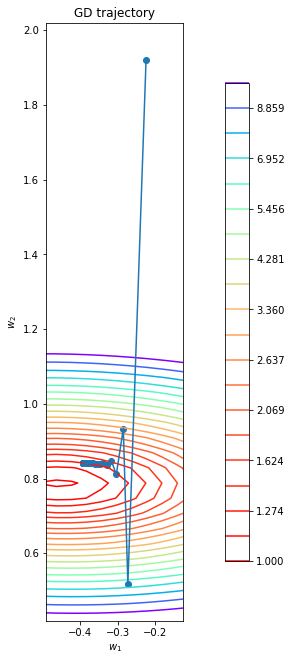

lr равен 0.01, batch_size равен 10 loss = 1.2384176865119914




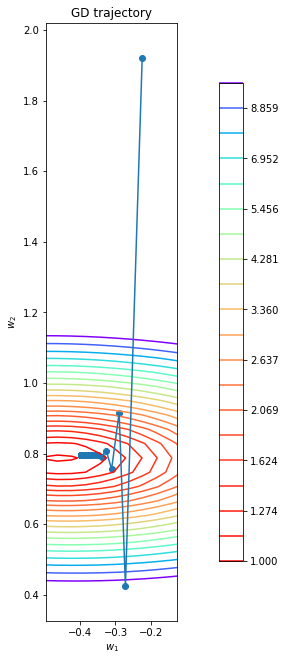

lr равен 0.01, batch_size равен 50 loss = 1.0153243082427104




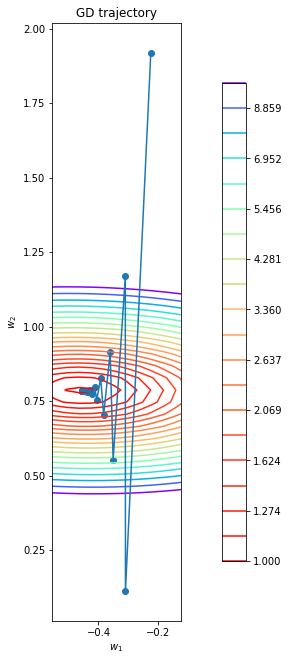

lr равен 0.01, batch_size равен 100 loss = 0.9746914409572346




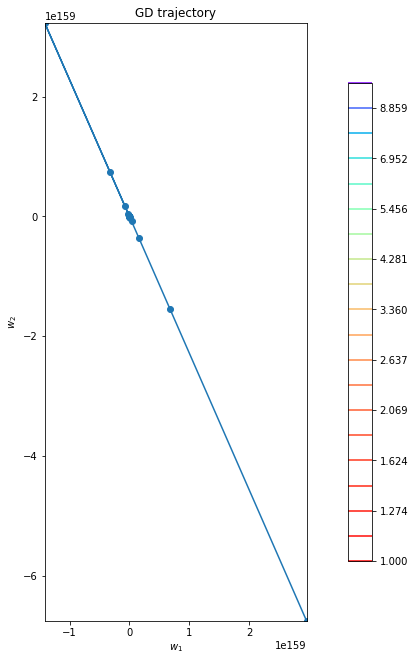

lr равен 0.014, batch_size равен 1 loss = inf




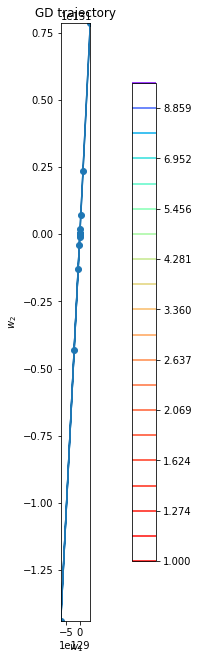

lr равен 0.014, batch_size равен 10 loss = 1.5511849734183077e+264




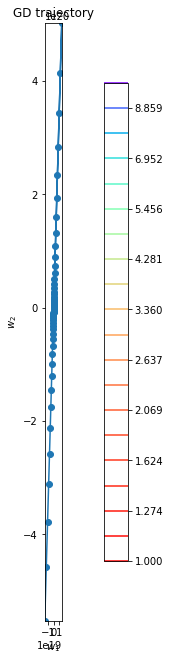

lr равен 0.014, batch_size равен 50 loss = 2.284990240888201e+43




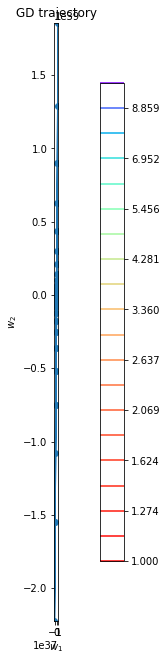

lr равен 0.014, batch_size равен 100 loss = 3.694859089585108e+80




In [19]:
# -- YOUR CODE HERE --
# -- YOUR CODE HERE --
lr_list = [0.0001, 0.001, 0.005, 0.01, 0.014]
batch_size_list = [1, 10, 50, 100]
res_list = []
loss = MSELoss()
for i in lr_list:
    for j in batch_size_list:
        w_list = stochastic_gradient_descent(w_init, X, y, loss, lr=i, batch_size=j, n_iterations = 500)
        plot_gd(w_list, X=X, y=y, loss = loss)
        loss_res = loss.calc_loss(X, y, w_list[-1])
        res_list.append([i, j,loss_res ])
        print(f'lr равен {i}, batch_size равен {j}', f'loss = {loss_res}', end = '\n\n\n')



In [20]:
min_loss = sorted(res_list, key= lambda x: x[2])[:5]
max_loss = sorted(res_list, key= lambda x: x[2], reverse=True)[:5]

In [21]:
print('min', min_loss, sep ='\n')
print('max', max_loss, sep = '\n')

min
[[0.001, 100, 0.9743969648375636], [0.01, 100, 0.9746914409572346], [0.005, 50, 0.9795348297965143], [0.001, 50, 0.9993519490405315], [0.005, 100, 1.0064807226603945]]
max
[[0.014, 1, inf], [0.014, 10, 1.5511849734183077e+264], [0.014, 100, 3.694859089585108e+80], [0.014, 50, 2.284990240888201e+43], [0.0001, 1, 74.37996585480691]]


### Conclusions
I displayed 5 configurations [lr, batch_size, loss] with minimum and maximum loss. Among the best options, we can note that all 5 configurations have batch_size equal to either 50 or 100, which is quite obvious; it is better to focus on a larger number of objects in the sample, since in general, in the task of minimizing the error, we are trying to obtain some kind of generalizing ability. It is also worth noting, a rather interesting fact, that in the 5 best configurations there are both large lr and small ones (there is 0.001, and there is 0.01), however, the smallest (0.0001) step turned out to be irrelevant; in 500 steps we simply do not have time to reach the minimum loss functions. Also, the largest step 0.014 turned out to be irrelevant, since with such a step it is difficult to get to this minimum. Among the worst configurations, we can note combinations with batch_size equal to 1, which is obviously very 'adventurous' to use, since we do not know how well this random object fits into the sample. We can also note the configuration with a step of 0.014, which turned out to be bad, despite the batch size of 50 or 100. Again, the theory that we are “flying” past the minimum is confirmed. My conclusions are also confirmed by the graphs (0.0001 is not enough to reach the minimum, but with a large step we fly by. With a small batch we go in the wrong direction at all.)

You may have noticed that the behavior of gradient descent, especially the stochastic version, is very dependent on the step size.

As a rule, at the beginning of the descent we want to take large steps in order to quickly get closer to the minimum, and later we want to take small steps in order to more accurately reach this minimum and not “jump” over it.

To achieve this behavior, we can gradually decrease the step length as the iteration number increases. This can be done, for example, by calculating the step length at each iteration using the following formula:

$$
     \eta_t
     =
     \lambda
     \left(
         \frac{s_0}{s_0 + t}
     \right)^p
$$

where $\eta_t$ is the step length at iteration $t$, $\lambda$ is the initial step length (our `lr` parameter), $s_0$ and $p$ are configurable parameters.

**Task 1.6 (5/8 points):** Implement the `stochastic_gradient_descent` function, this time with a decaying step using the formula above. Take the $s_0$ parameter equal to 1. Take the $p$ parameter from the new function argument `p`.

In [31]:
def stochastic_gradient_descent_p(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Gradient descent function
     :param w_init: np.ndarray of size (n_feratures,) -- initial value of the weights vector
     :param X: np.ndarray of size (n_objects, n_features) -- matrix of object-features
     :param y: np.ndarray of size (n_objects,) -- vector of correct answers
     :param loss: An object of the BaseLoss subclass that can calculate gradients using loss.calc_grad(X, y, w)
     :param lr: float -- step size parameter by which to multiply the gradient
     :param batch_size: int -- size of the subsample to be sampled at each step
     :param p: float -- the value of the degree in the step length attenuation formula
     :param n_iterations: int -- how many iterations to do
     :return: List of n_iterations np.ndarray objects of size (n_features,) -- history of weights at each step
    """
    # -- YOUR CODE HERE --
    batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
    batch_x = X[batch_indices]
    bacth_y = y[batch_indices]


    listt  = []
    for i in range(n_iterations):
        new_w = w_init - (lr*(1/(1+i))**p * loss.calc_grad(batch_x, bacth_y, w_init))
        listt.append(w_init)
        w_init = new_w
    return listt

**Task 1.7 (5/8 points):** Using the new `stochastic_gradient_descent` function and the `plot_gd` function, draw a gradient descent trajectory for different values of the `p` parameter. Use at least four different values for `p`. Good values can be between 0.1 and 1.
Set the `lr` parameter equal to 0.01, and the `batch_size` parameter equal to 10.

Draw and describe your conclusions about how the `p` parameter affects the behavior of stochastic gradient descent

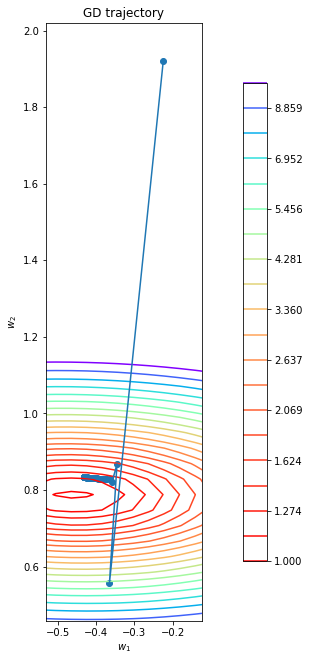

p равен 0.1 loss = 1.1447489214323563




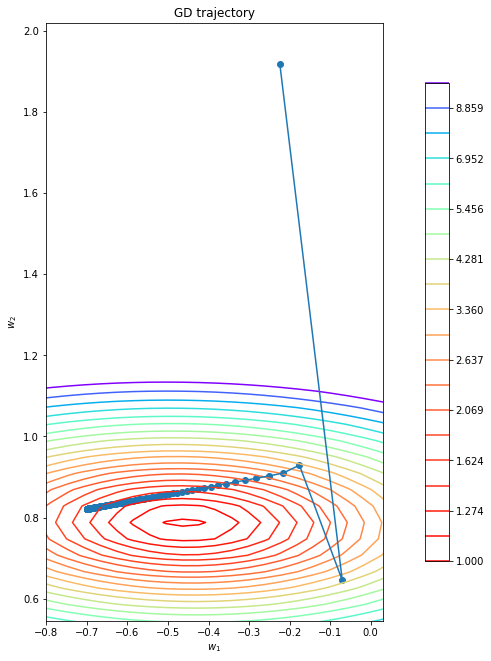

p равен 0.3 loss = 1.5405152406207738




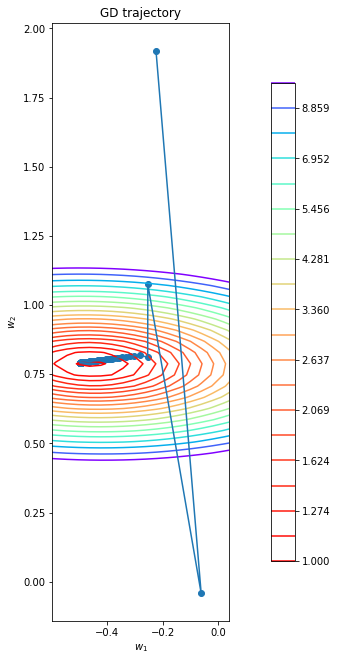

p равен 0.5 loss = 0.9888846839673274




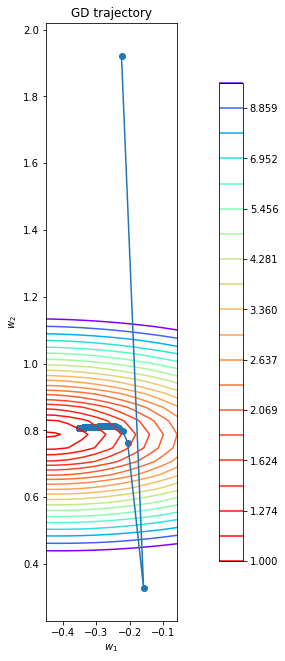

p равен 0.7 loss = 1.1113847491288447




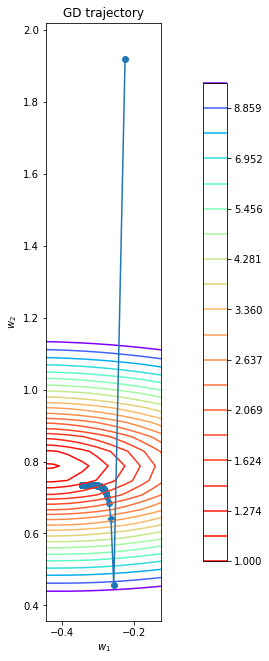

p равен 0.9 loss = 1.2673319396228562




In [36]:
# -- YOUR CODE HERE --

res_list = []
p_list = [0.1, 0.3, 0.5, 0.7, 0.9]
loss = MSELoss()
for p in p_list:
    w_list = stochastic_gradient_descent(w_init, X, y, loss, lr=0.01, batch_size=10, p = p, n_iterations = 600)
    plot_gd(w_list, X=X, y=y, loss = loss)
    loss_res = loss.calc_loss(X, y, w_list[-1])
    res_list.append([p,loss_res ])
    print(f'p равен {p}', f'loss = {loss_res}', end = '\n\n\n')



### Выводы
Мы можем заметить, что при заданной конфигурации p не очень сильно влияет на результаты модели, однако в случае, в котором p велик (и шаг очень быстро утухает), мы не успеваем дойти до минимума. При p равным 0.5 модель показывает лучшие результаты, а при остальны p, мы можем видеть, что градиент уходит не совсем в правильное направление.

**Задание 1.8 (5/8 балла):** Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

#### Во-первых, заново зададим  стохатический градиентный спуск

In [54]:
def stochastic_gradient_descent_1(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """

    batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
    batch_x = X[batch_indices]
    bacth_y = y[batch_indices]


    listt  = []
    for i in range(n_iterations):
        new_w = w_init - (lr * loss.calc_grad(batch_x, bacth_y, w_init))
        listt.append(w_init)
        w_init = new_w
    


   
    
    return listt 
    


In [39]:
import matplotlib.pyplot as plt

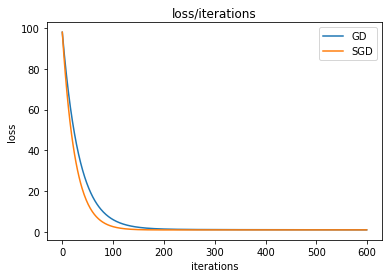

In [106]:
# -- YOUR CODE HERE --
w_list_s = stochastic_gradient_descent_1(w_init, X, y, loss, lr=0.0001, batch_size=10, n_iterations = 600)
w_list = gradient_descent(w_init, X, y, loss, lr=0.0001, n_iterations = 600)
gd_list = []
sgd_list = []
fig, ax = plt.subplots()
for i in range(600):
    loss_res_gd = loss.calc_loss(X, y, w_list[i])
    gd_list.append(loss_res_gd)
    loss_res_sgd = loss.calc_loss(X, y, w_list_s[i])
    sgd_list.append(loss_res_sgd)
ax.plot(range(600), gd_list , label='GD')
ax.plot(range(600), sgd_list, label = 'SGD')
ax.set_xlabel('iterations')
ax.set_ylabel('loss')
ax.set_title('loss/iterations')
ax.legend()

# Display the plot
plt.show()





## Conclusions
For this task, I restarted the cell several times and accordingly changed the batch that is selected for SGD. The results varied greatly depending on the run, sometimes SGD was better, sometimes vice versa, sometimes the error values were the same. It is worth noting that the loss/iterations function should not show better results with SGD, since the advantage of SGD is in the speed of action, and not in finding the minimum faster. Sometimes SGD does a better job when a batch is found that describes our data as accurately as possible (there are no outliers or anomalies in the batch), sometimes we are unlucky and not entirely representative data ends up in the batch. As a result, there is no clear relationship between the method (SGD/GD) and loss/iterations.

## Part 2. Linear regression (5 points)

Now let's write our linear regression class. It will use the interface we are familiar with from the `sklearn` library.

In the `fit` method we will select the weights `w` using gradient descent with our `gradient_descent` method

In the `predict` method we will apply our regression to the dataset,

**Task 2.1 (5/8 points):** Add code in the `fit` and `predict` methods of the `LinearRegression` class

In the `fit` method you need to somehow initialize the `w` weights, apply `gradient_descent` and save the last `w` from the trajectory.

In the `predict` method you need to apply linear regression and return a vector of responses.

Note that the loss object is passed in at initialization and is stored in `self.loss`. It should be used in `fit` for `gradient_descent`.

In [108]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
       # Add a column of units for a constant attribute
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        self.w = np.random.uniform(-2, 2, (X[0].shape[0]))
        self.w_list = gradient_descent(self.w, X, y, self.loss, self.lr, 700)
        self.w= self.w_list[-1]


        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Check that the regression is trained, that is, that fit was called and the self.w attribute was set in it
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Add a column of units for a constant attribute
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        return X.dot(self.w)

Now we have our linear regression class. Moreover, we can control which loss function we optimize by simply passing different classes to the `loss` parameter upon initialization.

For now we don't have any classes other than `MSELoss`, but they will be coming soon.

For `MSELoss` we would create our linear regression object like this:

In [109]:
linear_regression = LinearRegression(MSELoss())

Let's apply our regression on a real dataset. Let's download the dataset with cars that you had at the seminars:

In [163]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [164]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

**Task 2.2 (5/8 points):** As usual, process the dataset with all the necessary methods so that linear regression can be trained on it:

* Divide the dataset into a training and test set
* Fill the gaps
* Normalize numeric attributes
* Code categorical variables

In [165]:
X_raw.head(1)

,index,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27


In [166]:
X_raw.drop('index', axis=1, inplace=True)

In [167]:
print(X_raw.select_dtypes(include='object').columns)
print(X_raw.select_dtypes(exclude='object').columns)

Index([2, 3, 4, 5, 6, 7, 8, 14, 15, 17], dtype='object')
Index([0, 1, 9, 10, 11, 12, 13, 16, 18, 19, 20, 21, 22, 23, 24], dtype='object')


In [168]:
categorical = [2, 3, 4, 5, 6, 7, 8, 14, 15, 17]
numerical = [0, 1, 9, 10, 11, 12, 13, 16, 18, 19, 20, 21, 22, 23, 24]

In [169]:
for column in categorical:
    X_raw[column].fillna(X_raw[column].mode()[0], inplace=True)

In [170]:
for column in numerical:
    X_raw[column].fillna(X_raw[column].median(), inplace=True)

In [171]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [172]:
scaler = StandardScaler()
X_raw[numerical] = scaler.fit_transform(X_raw[numerical])

In [173]:
X = pd.get_dummies(X_raw, columns = categorical, drop_first = True)


In [174]:
X

,0,1,9,10,11,12,13,16,18,19,...,15_three,15_twelve,15_two,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
0,1.725050,-0.178306,-1.685107,-0.439409,-0.853460,-2.034081,-0.014858,0.075389,0.522405,-1.831820,...,0,0,0,0,0,0,0,1,0,0
1,1.725050,-0.178306,-1.685107,-0.439409,-0.853460,-2.034081,-0.014858,0.075389,0.522405,-1.831820,...,0,0,0,0,0,0,0,1,0,0
2,0.127193,-0.178306,-0.710103,-0.244152,-0.185597,-0.559713,0.518080,0.606234,-2.431752,0.673776,...,0,0,0,0,0,0,0,1,0,0
3,0.926121,1.351431,0.165748,0.195176,0.148335,0.218425,-0.423766,-0.431327,-0.524638,0.451761,...,0,0,0,0,0,0,0,1,0,0
4,0.926121,1.351431,0.099646,0.195176,0.243744,0.218425,0.520017,0.220165,-0.524638,0.451761,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,-1.470664,-0.802689,1.702619,1.187733,1.436357,0.709881,0.768075,0.340812,1.681631,-0.341149,...,0,0,0,0,0,0,0,1,0,0
197,-1.470664,-0.802689,1.702619,1.187733,1.388653,0.709881,0.956057,0.340812,1.681631,-0.341149,...,0,0,0,0,0,0,0,1,0,0
198,-1.470664,-0.802689,1.702619,1.187733,1.436357,0.709881,0.884353,1.112950,0.933744,-1.229208,...,0,0,0,0,0,0,0,1,0,0
199,-1.470664,-0.802689,1.702619,1.187733,1.436357,0.709881,1.281633,0.437329,-1.197737,0.451761,...,0,0,0,0,0,1,0,0,0,0


In [175]:
from sklearn.model_selection import train_test_split

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=505)

**Task 2.3 (5/8 points):** Train the linear regression you wrote on the training set

In [177]:
# -- YOUR CODE HERE --
linear_regression.fit(X_train, y_train)

**Task 2.4 (5/8 points):** Calculate the error of the trained regression on the training and test samples using the `mean_squared_error` method from `sklearn.metrics`.

In [181]:
from sklearn.metrics import mean_squared_error

# -- YOUR CODE HERE --
y_pred = linear_regression.predict(X_test)
y_train_pred = linear_regression.predict(X_train)
print('test', mean_squared_error(y_pred, y_test))
print('train', mean_squared_error( y_train_pred, y_train))



test 4362097.572442754
train 2550808.488335676


Our model has been overfitted. Let's add L2 regularization to it as usual in such a situation. To do this we need to write a new loss class.

The loss function formula for MSE with L2 regularization looks like this:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w| |^2
$$

Or in matrix form:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Where $\lambda$ is the regularization coefficient

The gradient looks like this:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Task 2.5 (5/8 points):** Implement the `MSEL2Loss` class

It should calculate the loss and gradient using the formulas above

Hint: note that the last element of the vector `w` is bias (in the `LinearRegression` class a column of ones is added to the `X` matrix - a constant attribute). As we know from lectures and seminars, bias does not need to be regularized. Therefore, do not forget to remove the last element from `w` when calculating the $\lambda||w||^2$ term in `calc_loss` and set it to zero when calculating the $2 \lambda w$ term in `calc_grad`

In [183]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: regularization coefficient (lambda in formula)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Function for calculating loss value
         :param X: np.ndarray of size (n_objects, n_features) with dataset objects. The last sign is constant.
         :param y: np.ndarray of size (n_objects,) with correct answers
         :param w: np.ndarray of size (n_features,) with linear regression weights. The last weight is bias.
         :output: number -- loss function values
         """
         # -- YOUR CODE HERE --
         # Compute the value of the loss function using X, y and w and return it
        loss_weights = np.linalg.norm(w[:-1]**2) * self.coef
        loss_base = np.linalg.norm(X.dot(w) - y)**2/y.shape[0]
        return loss_weights + loss_base

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
            Function for calculating the loss gradient by weights w
            :param X: np.ndarray of size (n_objects, n_features) with dataset objects
            :param y: np.ndarray of size (n_objects,) with correct answers
            :param w: np.ndarray of size (n_features,) with linear regression weights
            :output: np.ndarray of size (n_features,) gradient of the loss function over weights w
            """
            # -- YOUR CODE HERE --
            # Compute the value of the gradient vector using X, y and w and return it
        grad_base = 2/y.shape[0] * X.T@(X.dot(w) - y)
        grad_weights = 2*self.coef * np.hstack((w[:-1], 0))
        return grad_base + grad_weights
        

Now we can use loss with l2 regularization in our regression, for example like this:

In [184]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

**Task 2.6 (5/8 points):** Train regression with loss `MSEL2Loss`. Choose a good regularization coefficient and improve the result on the test sample. Compare the result on the training and test set with regression without regularization.

In [192]:
# -- YOUR CODE HERE --
lambdas = [0,0.001, 0.005, 0.01, 0.1, 1, 10]
for lambdaa in lambdas:
    model = LinearRegression(MSEL2Loss(lambdaa))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print(f'lambda={lambdaa}')
    print('test', mean_squared_error(y_pred, y_test))
    print('train', mean_squared_error( y_train_pred, y_train), end = '\n\n')
    

lambda=0
test 4362217.758910286
train 2550812.810715074

lambda=0.001
test 4281307.837567279
train 2615367.1471952065

lambda=0.005
test 4082559.8878859733
train 2907634.020582285

lambda=0.01
test 3999261.4047044995
train 3284418.5550267347

lambda=0.1
test 5429422.632151587
train 6407601.864517718

lambda=1
test 12071486.686678207
train 12807214.68499697

lambda=10
test inf
train inf



/Users/dmitrysakharov/opt/anaconda3/envs/cat/lib/python3.9/site-packages/sklearn/metrics/_regression.py:442: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/Users/dmitrysakharov/opt/anaconda3/envs/cat/lib/python3.9/site-packages/sklearn/metrics/_regression.py:442: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)


## Conclusions
On the train sample, the results with regularization are slightly worse than without, this is due to the fact that on the train sample, retraining is only in our favor. On the test sample, we see an improvement (from 4.6m to 4.0m), which shows that we are slightly solving the problem of overfitting thanks to regularization.

There may be outliers in our dataset. At the seminar you were told that Huber Loss helps to combat emissions well. Away from zero it behaves like Mean Absolute Error and does not respond to outliers as much as MSE. Let's implement it and apply it in our regression.

Recall that the Huber Loss function looks like this:


$$
     Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
     \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), otherwise \\ \end{cases}
$$


And the gradient is like this:
$$
     \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
     \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), otherwise \\ \end{cases}
$$

**Task 2.7 (5/8 points):** Implement the `HuberLoss` class

It should calculate the loss and gradient using the formulas above

In [ ]:
class HuberLoss(BaseLoss):
     def __init__(self, eps: float) -> None:
         """
         :param eps: huber loss parameter from the formula
         """
         self.eps = eps

     def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
         """
         Function for calculating loss value
         :param X: np.ndarray of size (n_objects, n_features) with dataset objects
         :param y: np.ndarray of size (n_objects,) with correct answers
         :param w: np.ndarray of size (n_features,) with linear regression weights
         :output: number -- loss function values
         """
         # -- YOUR CODE HERE --
         # Compute the value of the loss function using X, y and w and return it
         z = X.dot(w) - y
         f = (abs(z)>=self.eps)*(self.eps*(abs.z -0.5*self.eps)) + (abs(z)<self.eps)*0.5*(z**2 )
         return np.mean(f)

     def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
         """
         Function for calculating the loss gradient by weights w
         :param X: np.ndarray of size (n_objects, n_features) with dataset objects
         :param y: np.ndarray of size (n_objects,) with correct answers
         :param w: np.ndarray of size (n_features,) with linear regression weights
         :output: np.ndarray of size (n_features,) gradient of the loss function over weights w
         """
         # -- YOUR CODE HERE --
         # Compute the value of the gradient vector using X, y and w and return it
         z = X.dot(w) - y
         f = (abs(z)<self.eps)*(z) + (abs(z)>=self.eps)*(self.eps * np.sign(z))
         return np.mean(f)

**Task 2.8 (5/8 points):** Train regression with `HuberLoss`. Compare the result on the training and test set with the regression trained with `MSELoss`.

In [201]:
# -- YOUR CODE HERE --
for eps in [0.1, 1, 10]:
    model = LinearRegression(HuberLoss(eps=eps))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print(f'eps = {eps}')
    print('test', mean_squared_error(y_pred, y_test))
    print('train', mean_squared_error( y_train_pred, y_train), end = '\n\n')

eps = 0.1
test 252423079.11191925
train 229625275.42849335

eps = 1
test 232546182.420394
train 213202488.24902523

eps = 10
test 84633387.80028804
train 89274941.18536575



## As we can see, the results on the test and train samples for huber_loss are practically the same. We can say that in this case there is almost no overfitting; by ignoring outliers, we obtained a very high generalizing ability of the model

### BONUS (2.5 points)

Gradient descent is far from the only optimization method.
Another very famous method is called ["Simulated Annealing Algorithm"](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0). It's not often used to optimize machine learning models, but here's a unique opportunity to try applying it to our favorite linear regression.

**Task (2.5 points)**:
Write a simulated annealing algorithm to optimize the MSE of linear regression.

Compare the result with gradient descent along the “trajectory” and with the final loss.

Hint: each new point (regression weights in our case) can be sampled from some random distribution centered at the current point. Distributions with “heavy” tails are well suited, for example, the Student distribution with a parameter for the number of degrees of freedom in the region of 3.
It might look like this, for example:
```
new_w = old_w + np.random.standard_t(3, size=old_w.shape)
```
You can experiment with the distribution parameter: the larger it is, the less often new points will move very far away from the old ones.

In [214]:
# -- YOUR CODE HERE --

def otgig(X, y, n_iterations =5000, temp_init=15, coef=0.98):
    w = np.random.uniform(-2, 2, (X.shape[1]))
    mse_loss = (np.linalg.norm(X.dot(w) - y))**2/y.shape[0]
    temp = temp_init
    w_list_1 = []
    for i in range(n_iterations):
        w_list_1.append(w)
        new_w = w + np.random.standard_t(4, size=w.shape) * temp
        mse_loss_new = (np.linalg.norm(X.dot(new_w) - y))**2/y.shape[0]
        delta = mse_loss_new - mse_loss
        
        if delta < 0:
            w = new_w
            mse_loss = mse_loss_new
        else:
            probability = np.exp(-delta/temp)
            if np.random.random() <= probability:
                w = new_w
                mse_loss = mse_loss_new
        
        temp*=coef
    
    return w_list_1

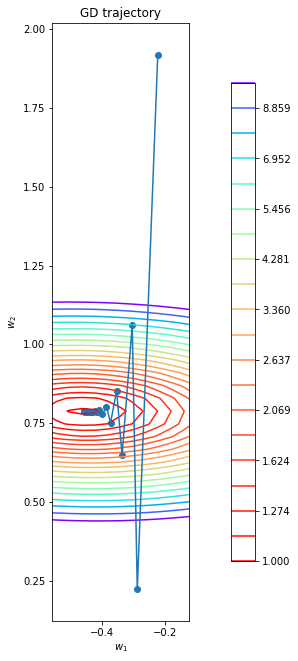

Градиентный спуск loss = 0.973880964221409




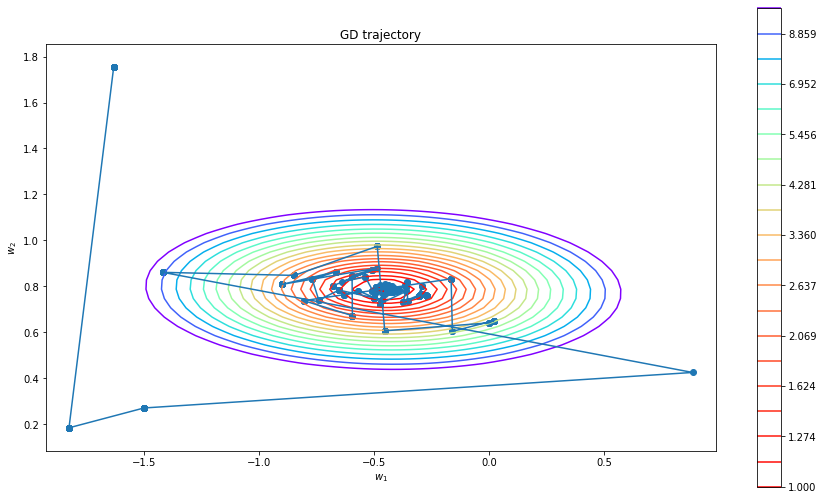

Отжиг loss = 0.9775233771725378




In [215]:
loss = MSELoss()

w_list = gradient_descent(w_init, X, y, loss, lr=0.01, n_iterations = 700)
w_list_1 = otgig(X, y, n_iterations =5000, temp_init=15, coef=0.98)
loss_res = loss.calc_loss(X, y, w_list[-1])
loss_res_1 = loss.calc_loss(X, y, w_list_1[-1])
plot_gd(w_list, X=X, y=y, loss = loss)
print('Градиентный спуск', f'loss = {loss_res}', end = '\n\n\n')
plot_gd(w_list_1, X=X, y=y, loss = loss)
print('Отжиг', f'loss = {loss_res_1}', end = '\n\n\n')



The first one is GD, the second one is Annealing Algorithm

## Conclusions
As we can see, annealing is much more chaotic, but the final loss of this method is almost as good as the gradient. This is also due to the large number of operations that I defined for annealing.